# Analyzing Aggravated Burglaries in Davidson County

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from IPython.display import Image
import json
import geopandas as gpd
from io import StringIO

Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial.

d. How do your models compare? Hint: the fit models have an AIC attribute.

Prepare a short presentation (<10 minutes) of your findings.

Additional Resources for Generalized Linear Models:

DataCamp - Generalized Linear Models in Python
Beyond Multiple Linear Regression, Chapter 4 Warning - the code in this book is all R, but the conceptual explanations are very clear.
This set of notes, which talks about the problem of overdispersion.

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'
params = {'offense_description':'BURGLARY- AGGRAVATED',
              '$where':'incident_occurred between \'2021-01-01\' and \'2021-06-30\'',
              '$limit':2000
              }
response = requests.get(endpoint, params = params)

In [3]:
agg_burg = gpd.read_file(StringIO(response.text))

In [4]:
# drop duplicate rows with the same incident_number
agg_burg=agg_burg.drop_duplicates(subset = ['incident_number'])

In [5]:
agg_burg

,victim_county_resident,zip_code,victim_number,offense_nibrs,rpa,latitude,victim_race,incident_number,investigation_status,offense_number,...,weapon_primary,report_type_description,victim_type,incident_status_code,incident_status_description,zone,victim_gender,incident_occurred,primary_key,geometry
0,RESIDENT,None,1,220,8203,36.15,B,20210249540,Open,1,...,09,DISPATCHED,I,O,OPEN,511,F,2021-05-04T23:45:00,20210249540_11,POINT (-86.77000 36.15000)
1,RESIDENT,None,1,220,9615,36.2,W,20210248840,Open,1,...,09,DISPATCHED,I,O,OPEN,525,F,2021-05-04T12:06:00,20210248840_11,POINT (-86.63000 36.20000)
2,NON RESIDENT,None,1,220,6901,36.14,W,20210244919,Open,1,...,17,DISPATCHED,I,O,OPEN,815,M,2021-05-01T23:00:00,20210244919_11,POINT (-86.78000 36.14000)
3,NON RESIDENT,None,3,220,None,36.14,W,20210244892,Open,1,...,17,DISPATCHED,I,O,OPEN,None,M,2021-05-01T21:30:00,20210244892_13,POINT (-86.78000 36.14000)
5,RESIDENT,None,2,220,8401,36.11,W,20210248402,Open,1,...,17,DISPATCHED,I,O,OPEN,313,F,2021-05-04T00:00:00,20210248402_12,POINT (-86.73000 36.11000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,RESIDENT,37013,1,220,8861,36.052,B,20210029313,Closed,1,...,01,DISPATCHED,I,A,CLEARED BY ARREST,327,F,2021-01-15T21:50:00,20210029313_11,POINT (-86.64700 36.05200)
1037,RESIDENT,37210,1,220,8201,36.152,B,20210073787,Closed,1,...,09,DISPATCHED,I,A,CLEARED BY ARREST,511,F,2021-02-06T12:00:00,20210073787_11,POINT (-86.76500 36.15200)
1038,RESIDENT,37207,1,220,3013,36.204,B,20210127915,Closed,1,...,17,DISPATCHED,I,A,CLEARED BY ARREST,631,M,2021-03-03T15:30:00,20210127915_11,POINT (-86.80700 36.20400)
1039,None,None,1,220,8655,36.05,None,20210126551,Open,1,...,17,None,B,O,OPEN,827,None,2021-02-23T10:30:00,20210126551_11,POINT (-86.72000 36.05000)


2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [6]:
census_tract=gpd.read_file('../data/tl_2019_47_tract/')

In [7]:
census_tract

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,47,157,022112,47157022112,221.12,Census Tract 221.12,G5020,S,3293232,0,+35.0282414,-090.0009887,"POLYGON ((-90.01257 35.02328, -90.01256 35.023..."
1493,47,073,050501,47073050501,505.01,Census Tract 505.01,G5020,S,83253173,0,+36.5659218,-082.7714427,"POLYGON ((-82.85011 36.54107, -82.84955 36.541..."
1494,47,073,050601,47073050601,506.01,Census Tract 506.01,G5020,S,23852225,177932,+36.5836443,-082.6318663,"POLYGON ((-82.68939 36.58793, -82.68936 36.588..."
1495,47,073,050602,47073050602,506.02,Census Tract 506.02,G5020,S,23381992,668716,+36.5467218,-082.6458382,"POLYGON ((-82.69446 36.54856, -82.69445 36.548..."


In [8]:
#convert the EPSG to 4326
census_tract = census_tract.to_crs('EPSG:4326')

In [9]:
# spatial join census_tract with agg_burg
burg_census = gpd.sjoin(agg_burg, census_tract,how='left', op = 'within')

In [10]:
burg_census

,victim_county_resident,zip_code,victim_number,offense_nibrs,rpa,latitude,victim_race,incident_number,investigation_status,offense_number,...,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,RESIDENT,None,1,220,8203,36.15,B,20210249540,Open,1,...,016000,47037016000,160,Census Tract 160,G5020,S,1158914.0,0.0,+36.1454955,-086.7638143
1,RESIDENT,None,1,220,9615,36.2,W,20210248840,Open,1,...,015402,47037015402,154.02,Census Tract 154.02,G5020,S,8571300.0,163135.0,+36.1898464,-086.6494215
2,NON RESIDENT,None,1,220,6901,36.14,W,20210244919,Open,1,...,016200,47037016200,162,Census Tract 162,G5020,S,1834986.0,8826.0,+36.1384775,-086.7809810
3,NON RESIDENT,None,3,220,None,36.14,W,20210244892,Open,1,...,016200,47037016200,162,Census Tract 162,G5020,S,1834986.0,8826.0,+36.1384775,-086.7809810
5,RESIDENT,None,2,220,8401,36.11,W,20210248402,Open,1,...,017401,47037017401,174.01,Census Tract 174.01,G5020,S,1908746.0,0.0,+36.1133030,-086.7274160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,RESIDENT,37013,1,220,8861,36.052,B,20210029313,Closed,1,...,015628,47037015628,156.28,Census Tract 156.28,G5020,S,2163929.0,0.0,+36.0532074,-086.6572042
1037,RESIDENT,37210,1,220,8201,36.152,B,20210073787,Closed,1,...,014800,47037014800,148,Census Tract 148,G5020,S,759493.0,0.0,+36.1510966,-086.7597079
1038,RESIDENT,37207,1,220,3013,36.204,B,20210127915,Closed,1,...,012702,47037012702,127.02,Census Tract 127.02,G5020,S,4518555.0,232757.0,+36.2054178,-086.7959672
1039,None,None,1,220,8655,36.05,None,20210126551,Open,1,...,019105,47037019105,191.05,Census Tract 191.05,G5020,S,2176555.0,0.0,+36.0513279,-086.7242603


In [11]:
burg_census['NAMELSAD'].value_counts().index[0]

'Census Tract 163'

3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [12]:
with open('../data/census.json') as fi:
    credentials = json.load(fi)
api_key = credentials['api_key']

In [13]:
# population in the detailed tables
endpoint = 'https://api.census.gov/data/2019/acs/acs5'
params = {
          'get': 'NAME,B01001_001E',
          'for':'tract:*',
          'in' : ['state:47', 'county:037'],
          'key':api_key
        }
response = requests.get(endpoint, params = params)

#get=NAME,B01001_001E&for=tract:*&in=state:01&in=county:*&key=YOUR_KEY_GOES_HERE

In [14]:
print(response.url)

https://api.census.gov/data/2019/acs/acs5?get=NAME%2CB01001_001E&for=tract%3A%2A&in=state%3A47&in=county%3A037&key=a2b3ec937c5c5e437b9e4395287b5d91d1539fc3


In [15]:
endpoint

'https://api.census.gov/data/2019/acs/acs5'

In [16]:
params

{'get': 'NAME,B01001_001E',
 'for': 'tract:*',
 'in': ['state:47', 'county:037'],
 'key': 'a2b3ec937c5c5e437b9e4395287b5d91d1539fc3'}

In [17]:
pop=pd.read_json(response.text)

In [18]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       162 non-null    object
 1   1       162 non-null    object
 2   2       162 non-null    object
 3   3       162 non-null    object
 4   4       162 non-null    object
dtypes: object(5)
memory usage: 6.5+ KB


In [19]:
pop = pop[1:].rename(columns = {0:"name", 1:"population",2:'state',3:'county', 4:'track'})

In [20]:
pop.sort_values('population')

,name,population,state,county,track
75,"Census Tract 9802, Davidson County, Tennessee",0,47,037,980200
74,"Census Tract 9801, Davidson County, Tennessee",0,47,037,980100
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
40,"Census Tract 182.03, Davidson County, Tennessee",1392,47,037,018203
86,"Census Tract 191.14, Davidson County, Tennessee",14022,47,037,019114
...,...,...,...,...,...
72,"Census Tract 195, Davidson County, Tennessee",7956,47,037,019500
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301
121,"Census Tract 130, Davidson County, Tennessee",877,47,037,013000
134,"Census Tract 156.10, Davidson County, Tennessee",9141,47,037,015610


In [21]:
# median income
endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
params = {
          'get': 'NAME,S1901_C01_012E',
          'for':'tract:*',
          'in' : ['state:47', 'county:037'],
          'key':api_key
        }
response = requests.get(endpoint, params = params)

In [22]:
median_income = pd.read_json(response.text)

In [23]:
# delete the first row and rename the columns
median_income=median_income[1:].rename(columns = {0:"name", 1:"median_income",2:'state',3:'county', 4:'track'})

In [24]:
# merge pop with median_income
pop_income = pd.merge(pop,median_income, on = 'name')

In [25]:
# extract the Census Track from the name column of pop_income dataframe and save it to a new column NAMELSAD
pop_income['NAMELSAD']=pop_income['name'].apply(lambda x :x.split(',')[0])

In [26]:
pop_income

,name,population,state_x,county_x,track_x,median_income,state_y,county_y,track_y,NAMELSAD
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75579,47,037,015631,Census Tract 156.31
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,45129,47,037,015804,Census Tract 158.04
2,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701,134786,47,037,017701,Census Tract 177.01
3,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702,107813,47,037,017702,Census Tract 177.02
4,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,87591,47,037,018301,Census Tract 183.01
...,...,...,...,...,...,...,...,...,...,...
156,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613,37656,47,037,015613,Census Tract 156.13
157,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620,54149,47,037,015620,Census Tract 156.20
158,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100,48221,47,037,016100,Census Tract 161
159,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400,50857,47,037,011400,Census Tract 114


In [27]:
# merge burg_census with pop_income on NAMELSAD column
burg_pop_income = pd.merge(burg_census,pop_income, on = 'NAMELSAD')

In [28]:
burg_pop_income.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 821 entries, 0 to 820
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   victim_county_resident       796 non-null    object  
 1   zip_code                     143 non-null    object  
 2   victim_number                821 non-null    object  
 3   offense_nibrs                821 non-null    object  
 4   rpa                          765 non-null    object  
 5   latitude                     821 non-null    object  
 6   victim_race                  796 non-null    object  
 7   incident_number              821 non-null    object  
 8   investigation_status         821 non-null    object  
 9   offense_number               821 non-null    object  
 10  offense_description          821 non-null    object  
 11  longitude                    821 non-null    object  
 12  domestic_related             821 non-null    bool    
 1

4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [29]:
burg_pop_income.geometry

0      POINT (-86.77000 36.15000)
1      POINT (-86.76000 36.14000)
2      POINT (-86.76000 36.14000)
3      POINT (-86.77000 36.15000)
4      POINT (-86.76000 36.14000)
                  ...            
816    POINT (-86.60200 36.19800)
817    POINT (-86.73000 36.19000)
818    POINT (-86.72700 36.19300)
819    POINT (-86.75800 36.05100)
820    POINT (-86.74400 36.22900)
Name: geometry, Length: 821, dtype: geometry

In [30]:
burg_census_sum = (pd.DataFrame(burg_pop_income['NAMELSAD'].value_counts())
                   .reset_index()
                  .rename(columns={'NAMELSAD':'burg_sum','index':'NAMELSAD'}))

In [31]:
burg_census_sum

,NAMELSAD,burg_sum
0,Census Tract 163,53
1,Census Tract 162,21
2,Census Tract 110.01,20
3,Census Tract 193,19
4,Census Tract 195,18
...,...,...
144,Census Tract 179.01,1
145,Census Tract 186.01,1
146,Census Tract 179.02,1
147,Census Tract 132.02,1


In [32]:
census_tract_davison = census_tract[census_tract['COUNTYFP']=='037']

In [51]:
burg_census_merged = (pd.merge(census_tract_davison,burg_census_sum, on = 'NAMELSAD', how= 'left')
 .fillna(value={'burg_sum':0}))
burg_census_pop_income=pd.merge(left = burg_census_merged,
                         right = pop_income,
                        on = 'NAMELSAD')

In [52]:
burg_census_pop_income = burg_census_pop_income.astype({'population':'int64', 'median_income':'int64'})


In [53]:
burg_census_pop_income.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   STATEFP        161 non-null    object  
 1   COUNTYFP       161 non-null    object  
 2   TRACTCE        161 non-null    object  
 3   GEOID          161 non-null    object  
 4   NAME           161 non-null    object  
 5   NAMELSAD       161 non-null    object  
 6   MTFCC          161 non-null    object  
 7   FUNCSTAT       161 non-null    object  
 8   ALAND          161 non-null    int64   
 9   AWATER         161 non-null    int64   
 10  INTPTLAT       161 non-null    object  
 11  INTPTLON       161 non-null    object  
 12  geometry       161 non-null    geometry
 13  burg_sum       161 non-null    float64 
 14  name           161 non-null    object  
 15  population     161 non-null    int64   
 16  state_x        161 non-null    object  
 17  county_x       161 non-null

In [54]:
burg_census_pop_income['burg_rate']= burg_census_pop_income['burg_sum']/burg_census_pop_income['population']*1000
burg_census_pop_income

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,name,population,state_x,county_x,track_x,median_income,state_y,county_y,track_y,burg_rate
0,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,...,"Census Tract 101.06, Davidson County, Tennessee",3397,47,037,010106,63864,47,037,010106,2.060642
1,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418,61097,...,"Census Tract 101.03, Davidson County, Tennessee",2533,47,037,010103,70341,47,037,010103,0.000000
2,47,037,010202,47037010202,102.02,Census Tract 102.02,G5020,S,68394934,77571,...,"Census Tract 102.02, Davidson County, Tennessee",3962,47,037,010202,78750,47,037,010202,0.252398
3,47,037,010104,47037010104,101.04,Census Tract 101.04,G5020,S,65057846,251504,...,"Census Tract 101.04, Davidson County, Tennessee",2955,47,037,010104,64844,47,037,010104,1.692047
4,47,037,013300,47037013300,133,Census Tract 133,G5020,S,2764220,0,...,"Census Tract 133, Davidson County, Tennessee",3997,47,037,013300,69006,47,037,013300,3.002252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,47,037,018905,47037018905,189.05,Census Tract 189.05,G5020,S,1462431,0,...,"Census Tract 189.05, Davidson County, Tennessee",3247,47,037,018905,64537,47,037,018905,2.463813
157,47,037,013601,47037013601,136.01,Census Tract 136.01,G5020,S,2349100,0,...,"Census Tract 136.01, Davidson County, Tennessee",3320,47,037,013601,26946,47,037,013601,1.204819
158,47,037,018301,47037018301,183.01,Census Tract 183.01,G5020,S,85850192,1506526,...,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,87591,47,037,018301,0.969227
159,47,037,018302,47037018302,183.02,Census Tract 183.02,G5020,S,49978667,13533,...,"Census Tract 183.02, Davidson County, Tennessee",2774,47,037,018302,96576,47,037,018302,0.360490


In [55]:
burg_census_pop_income = burg_census_pop_income.sort_values('burg_rate')[:-2]

<AxesSubplot:>

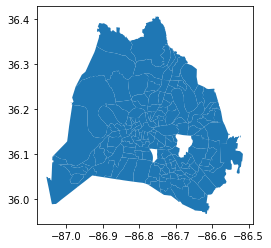

In [56]:
burg_census_pop_income.plot()

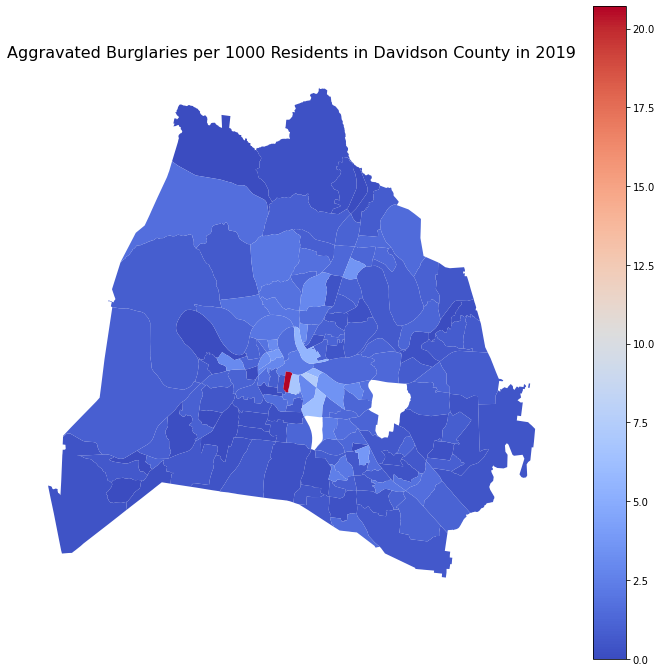

In [57]:
fig,ax = plt.subplots(figsize = (12,12))
burg_census_pop_income.plot(column = 'burg_rate',
                            cmap = 'coolwarm', 
                            legend = True,
                           ax = ax)
ax.axis('off')
plt.title('Aggravated Burglaries per 1000 Residents in Davidson County in 2019', fontsize = 16);

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

In [58]:
import statsmodels.api as sm

In [59]:
poisreg_burg_rate = (sm.GLM(endog = burg_census_pop_income['burg_rate'],
    exog = sm.add_constant(burg_census_pop_income[[]]),
    family = sm.families.Poisson())
    .fit()
)

In [60]:
poisreg_burg_rate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              burg_rate   No. Observations:                  159
Model:                            GLM   Df Residuals:                      158
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.42
Date:                Sat, 09 Oct 2021   Deviance:                       231.35
Time:                        13:00:55   Pearson chi2:                     454.
No. Iterations:                     5   Pseudo R-squ. (CS):          6.661e-16
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3153      0.068      4.655      0.000       0.183       0.448
==============================================================================
"""

b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).


In [61]:
poisreg_burg_rate = (sm.GLM(endog = burg_census_pop_income['burg_rate'],
    exog = sm.add_constant(burg_census_pop_income[['median_income']]),
    family = sm.families.Poisson())
    .fit()
)

In [63]:
poisreg_burg_rate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              burg_rate   No. Observations:                  159
Model:                            GLM   Df Residuals:                      157
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -265.78
Date:                Sat, 09 Oct 2021   Deviance:                       230.08
Time:                        13:01:17   Pearson chi2:                     450.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008008
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3228      0.068      4.754      0.000       0.190       0.456
median_income  1.375e-09   1.43e-09      0.961      0.337   -1.43e-09    4.18e-09
=================================================================================
"""

c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial.


In [66]:
poisreg_burg_rate.mu

array([1.38110228, 1.38110261, 1.38105769, 1.3813366 , 1.38108072,
       1.38105914, 1.38119353, 0.55215863, 1.38109416, 1.38128759,
       1.38102719, 1.38107823, 1.38116089, 1.38113081, 1.38106995,
       1.38121239, 1.38115674, 1.38108704, 1.38115679, 1.38111858,
       1.38107592, 1.38108777, 1.38106763, 1.38109168, 1.38107152,
       1.38111766, 1.38131801, 1.38107552, 1.38108298, 1.38105554,
       1.38115244, 1.38117378, 1.38106384, 1.3811102 , 1.3810662 ,
       1.38133059, 1.38118014, 1.38111256, 1.38110737, 1.38106561,
       1.38114307, 1.3811045 , 1.38107922, 1.38112637, 1.38112423,
       1.38114101, 1.38104054, 1.38120541, 1.38106449, 1.38117018,
       1.38111108, 1.38109235, 1.3810531 , 1.38109918, 1.38112385,
       1.38109188, 1.38106869, 1.38113753, 1.38104698, 1.38132679,
       1.3810691 , 1.38109663, 1.3810843 , 1.38105019, 1.38110621,
       1.38105788, 1.38106118, 1.38109438, 1.38108563, 1.38108968,
       1.38109316, 1.38107251, 1.38108781, 1.38108535, 1.38106

d. How do your models compare? Hint: the fit models have an AIC attribute.